# Supply Chain Analysis

Supply chain management is the process of planning, organizing, and controlling the flow of goods and services from suppliers to customers. Among many benefits such analysis provides, we can mention a few:
- *improvement in efficiency* - by optimizing the flow of goods and services, supply chain management can help businesses to reduce waste and improve productivity;
- *increased customer satisfaction* -by ensuring that products are available when and where customers need them, supply chain management can help businesses to improve customer satisfaction;
- *profit increase* - by making the customers happier with the service and optimal workflow, supply chain management can generate less cost and drive sales.

In this analysis we will take a look at company DataCo Group, fictional company, but insight from this analysis might be forwarded into real life problems and instances. The dataset comes from [this](https://www.kaggle.com/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis) page on Kaggle. Also as a person working somewhere near Supply Chains (I have experience in Order Processing and Content Management), I am excited to learn more about it.

## How is this analysis useful?
Although these data describe a made-up company, the insights and techniques used in this analysis can be used for any supply chain analysis. 

In the upcoming analysis, I will focus on my two main objectives:
- **Objective 1** - find out what works good for DataCo Global, what does not and looks weird - give data informed insight on the company, it's strong points and points to change;
- **Objective 2** - perform an ABC Analysis, to define the most profitable, most important products in the DataCo Group portfolio and suggest how to leverage this finding;
- **Objective 3** - draw conclusions, why the sales are down, or why perhaps this company had to forclose, based solenly on the data in this study and some of my experience.

In this analysis I will also be using `Tableau` as my visualization tool, more so than visualize data in the notebook. If you want to check out my dashboards right now, feel free to explote [my Tableau Public](https://public.tableau.com/app/profile/truposzeq/vizzes), all files related to this analysis are titled *Supply_Chain_Analysis_Dashboard_{number}*. I will also mention dashboards as I go with my findings.

# Imports

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from datetime import datetime
import pickle
import dataframe_image as dfi
from sca_functions import outliers, extended_describe, count_orders, count_items_ordered
import warnings
from abc_analysis import abc_analysis

warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

with open('data/supply_chain_dictionaties.pkl', 'rb') as file:
    dictionaries = pickle.load(file)

product_name = dictionaries[0]
department_name = dictionaries[1]
category_name = dictionaries[2]

In [104]:
df = pd.read_parquet('data/SupplyChainDataset_cleaned.parquet')
df['Order_time'] = df['Order_date'].dt.time
df['Shipping_time'] = df['Shipping_date'].dt.time
df['Shipping_date'] = df['Shipping_date'].dt.date
df['Order_date'] = df['Order_date'].dt.date
df.tail()

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
180514,TRANSFER,4.80,119.98,0,17,Caguas,Puerto Rico,6352,Home Office,PR,4,Europe,United Kingdom,67298,0.00,0.00,168193,0.04,2,119.98,Northern Europe,PROCESSING,365,59.99,Standard Class,2017-09-13,2017-09-09,09:08:00,Saturday,09:08:00,Wednesday,0
180515,TRANSFER,-93.59,116.99,0,18,Caguas,Puerto Rico,6352,Home Office,PR,4,Europe,United Kingdom,67298,13.00,0.10,168195,-0.80,1,129.99,Northern Europe,PROCESSING,403,129.99,Standard Class,2017-09-13,2017-09-09,09:08:00,Saturday,09:08:00,Wednesday,0
180516,TRANSFER,55.66,191.92,1,46,Grove City,United States,10088,Corporate,OH,7,Europe,France,67300,8.00,0.04,168197,0.29,4,199.92,Western Europe,PROCESSING,1014,49.98,Standard Class,2017-09-15,2017-09-09,09:50:00,Saturday,09:50:00,Friday,2
180517,TRANSFER,36.23,163.18,1,38,Grove City,United States,10088,Corporate,OH,6,Europe,France,67300,35.82,0.18,168198,0.22,1,199.00,Western Europe,PROCESSING,305,199.00,Standard Class,2017-09-15,2017-09-09,09:50:00,Saturday,09:50:00,Friday,2
180518,TRANSFER,135.29,287.86,1,38,Grove City,United States,10088,Corporate,OH,6,Europe,France,67300,11.99,0.04,168196,0.47,3,299.85,Western Europe,PROCESSING,295,99.95,Standard Class,2017-09-15,2017-09-09,09:50:00,Saturday,09:50:00,Friday,2


# Exploratory Data Analysis
## Objective 1 : Provide data oriented insight on the DataCo Global business situation.

In this part of the analysis I want to take a better look at the DataCo Global business situation. I will tahe a look on the data and with initial analysis try to find business problems. Then I will recognize some questions and answer them by modifying the data. 

This part will not include ABC analys, that is not answer which product bring in the most revenue and which are not essencial for DataCo Global. 

I will answer all of these question in this notebook and portray most of them in Tableau dashboards. I will also provide some simple visualizations in this notebook, for better understanding of data. I already did this with the whole dataset before I cleaned it and I was able to choore the columns that interest me the most. 

Let's see the how this dataset looks like.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Type                      180519 non-null  category
 1   Benefit_per_order         180519 non-null  float64 
 2   Sales_per_customer        180519 non-null  float64 
 3   Late_delivery_risk        180519 non-null  int64   
 4   Category_Id               180519 non-null  int64   
 5   Customer_City             180519 non-null  object  
 6   Customer_Country          180519 non-null  category
 7   Customer_Id               180519 non-null  int64   
 8   Customer_Segment          180519 non-null  category
 9   Customer_State            180519 non-null  object  
 10  Department_Id             180519 non-null  int64   
 11  Market                    180519 non-null  category
 12  Order_Country             180519 non-null  object  
 13  Order_Id                  180

In [4]:
df.shape

(180519, 32)

In [5]:
df.columns

Index(['Type', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk',
       'Category_Id', 'Customer_City', 'Customer_Country', 'Customer_Id',
       'Customer_Segment', 'Customer_State', 'Department_Id', 'Market',
       'Order_Country', 'Order_Id', 'Order_Item_Discount',
       'Order_Item_Discount_Rate', 'Order_Item_Id', 'Order_Item_Profit_Ratio',
       'Order_Item_Quantity', 'Sales', 'Order_Region', 'Order_Status',
       'Product_Card_Id', 'Product_Price', 'Shipping_Mode', 'Shipping_date',
       'Order_date', 'Order_time', 'Order_day', 'Shipping_time',
       'Shipping_day', 'Target_shipping_days'],
      dtype='object')

In [6]:
df.describe()

,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_Id,Department_Id,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Product_Card_Id,Product_Price,Target_shipping_days
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00
mean,21.97,183.11,0.55,31.85,6691.38,5.44,36221.89,20.66,0.10,90260.00,0.12,2.13,203.77,692.51,141.23,0.57
std,104.43,120.04,0.50,15.64,4162.92,1.63,21045.38,21.80,0.07,52111.49,0.47,1.45,132.27,336.45,139.73,1.49
min,-4274.98,7.49,0.00,2.00,1.00,2.00,1.00,0.00,0.00,1.00,-2.75,1.00,9.99,19.00,9.99,-2.00
25%,7.00,104.38,0.00,18.00,3258.50,4.00,18057.00,5.40,0.04,45130.50,0.08,1.00,119.98,403.00,50.00,0.00
50%,31.52,163.99,1.00,29.00,6457.00,5.00,36140.00,14.00,0.10,90260.00,0.27,1.00,199.92,627.00,59.99,1.00
75%,64.80,247.40,1.00,45.00,9779.00,7.00,54144.00,29.99,0.16,135389.50,0.36,3.00,299.95,1004.00,199.99,1.00
max,911.80,1939.99,1.00,76.00,20757.00,12.00,77204.00,500.00,0.25,180519.00,0.50,5.00,1999.99,1363.00,1999.99,4.00


In [7]:
df.isnull().sum().sum()

0

In [8]:
df.duplicated().sum()

0

### Numerical (and categorical) data analysis
In this part of the analysis I will take a closer look at the properties of numeric (especially continuous) columns, and to some extend their relations with each other and categorical features. 

I did separate the continuous data colums due to the fact that `Late_delivery_risk`, `Order_Item_Quantity` and `Target_shipping_days` have a narrow spread of values, the maximums and minimums are all posible and not extreme. Hence their interpretation will be done differently. 

In [9]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

continous_columns = ['Benefit_per_order', 'Sales_per_customer','Order_Item_Discount',
                     'Order_Item_Profit_Ratio', 'Sales', 'Product_Price']

In [10]:
ext_stat_continuous = extended_describe(df, continous_columns)
dfi.export(ext_stat_continuous,"graphs/Extended_statistics.png")
ext_stat_continuous

,Benefit_per_order,Sales_per_customer,Order_Item_Discount,Order_Item_Profit_Ratio,Sales,Product_Price
Mean,21.97,183.11,20.66,0.12,203.77,141.23
Standard deviation,104.43,120.04,21.80,0.47,132.27,139.73
Median,31.52,163.99,14.00,0.27,199.92,59.99
Sum,3966902.97,33054402.04,3730378.40,21779.01,36784735.01,25495158.68
Skewness,-4.74,2.89,3.04,-2.89,2.88,3.19
Kurtosis,71.38,23.92,25.23,10.16,23.94,23.31
Outliers count,18942.00,1943.00,7537.00,17300.00,488.00,2048.00
IQR Lower bound,-79.70,-110.15,-31.48,-0.34,-149.98,-174.99
IQR Upper bound,151.50,461.93,66.87,0.78,569.91,424.98


I created the extended describe to draw some additional statistics from the features, before we draw the graphs. I used also my outliers detection function, which  *returns all the outliers from a column in a dataframe, where values are outside of range(q1 - (1.5 * IQR), q3 + (1.5 * IQR))*. For reference I also called for some of the OG functions, available in the regular `describe`, whereas for min and max values I will be looking at the `describe` called earlier. 

With the **skewness** (and partially with the median) we can see, on which side of the mean we have most of outliers and on which opposing side we have more records, which are much more similar to the mean.  
None of these column have nowhere near symetric spread and most of these have quite a lot of outliers, which is suggested by the Outliers count. Also the Lower bound for negative skewness and Upper bound for positive skewness suggest, that the outliers are smaller or greater than the bound. 
The **negative skewness** implies left skewed distribution, where the outliers are on the left from mean (much smaller than mean) and majority of values are slightly (in comparison to the outliers) greater than mean. We can observe such skewness in `Benefit_per_order` and `Order_Item_Profit_Ratio` features.  
Rest of the features are characterized with **positive skewness**, which let's us know, that the outliers are much greater than the mean and majority of the data in the column are slightly smaller than the mean.

Another information from this table, **kurtosis** helps us draw the distibution of the features. All of the continuous columns in here have kustosis much greater than 3, which implies that the distibution is leptokurtic, with fat tails (many outliers) and long distibution. 

To interpret one of the features here, let's take the example of `Benefit_per_order`. With the overlook from the extended describe table, we see that the values in this column are left skewed, with majority of the orders having benefit per order greater than 21.97USD, but we also have almost 19k orders where the benefits were smaller than -79.7 USD, which means that on those 19k orders we lost over 1.5M USD. That's quite a loss, compared to almost 40M USD pure benefit from all the orders. Interpretation of therse outliers will be benefitial for the company, as it will help with recognision of the items that do not bring profits. 

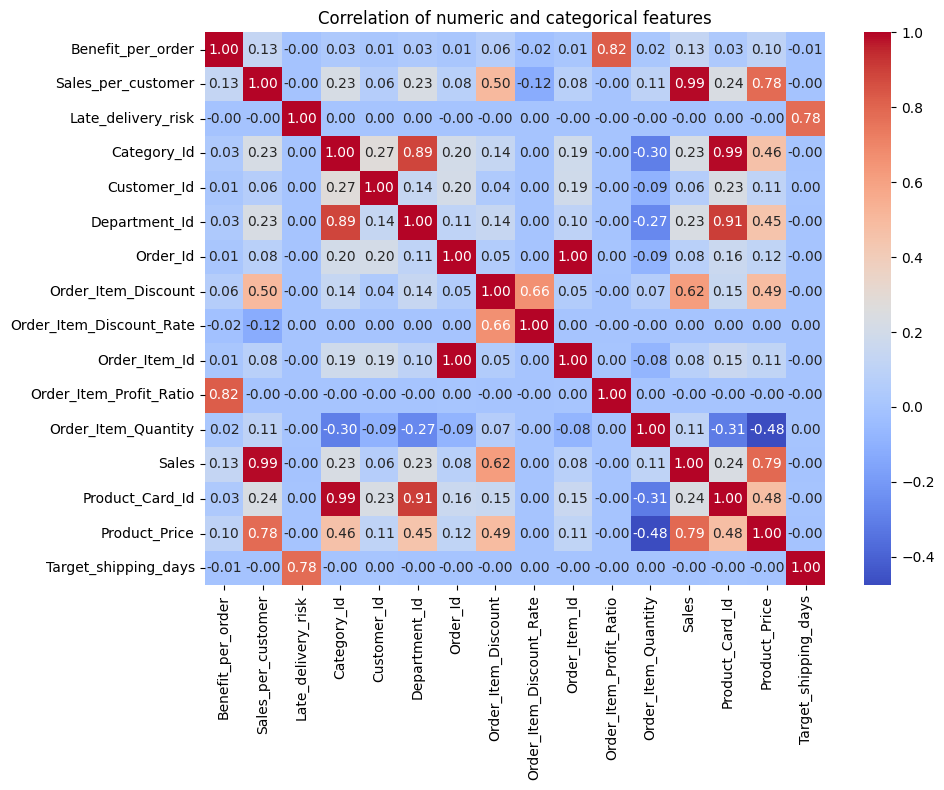

In [11]:
corr = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=',.2f')
plt.title('Correlation of numeric and categorical features')
plt.tight_layout()
plt.savefig('graphs/Correlogram.png')

plt.show()

With this Pearson correlation matrix, we can see the correlation between different columns. For now, I will focus on the continuous columns, same as before.

There is an extreme positive correlation between `Sales` and `Sales_per_customer`. In the previous table, these two had very similar skewness and kurtosis, which implies that these features have very similar distribution. Also, these are both sales, so what do we expect, right? Both of these are also quite highly positively correlated with `Product_price`. 

`Product_price` has quite a few interesting correlations beside that, it is somewhere positively correlated with `Order_Item_Discount`, which means the pricier the product, sometimes we might expect higher discount, and is also somewhere negatively correlated with `Order_Item_Quantity`, which is quite logical since the pricier the product, the less items we might order. 

Another correlation I find interesting is the high, positive correlation between `Order_Item_Profit_Ratio` and `Benefit_per_order`. What we can also take from the previous table is that both of these features have high volumes of outliers and both are left skewed, which perhaps suggest, that many of the outliers overlap.  We will take a look at this in the outlier analysis part.

First however, let's take a look at the visualization of the distributions.

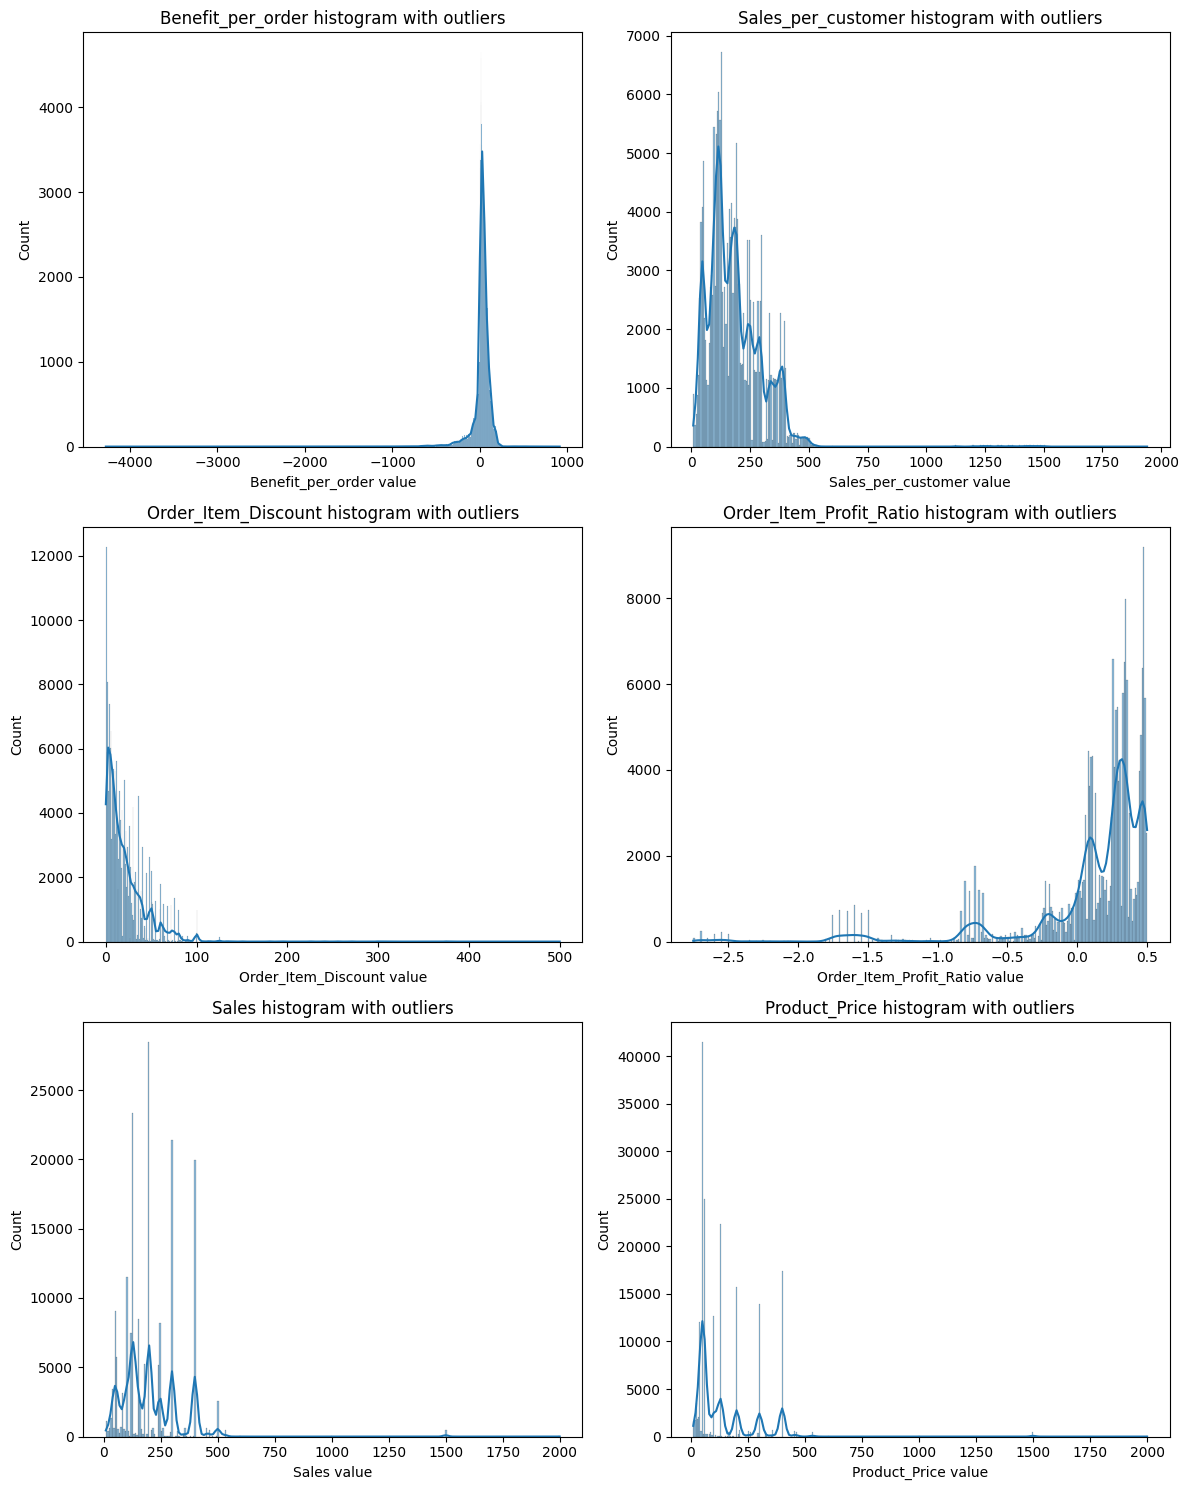

In [12]:
num_rows = len(continous_columns) // 2
if len(continous_columns) % 2 == 0:
    num_cols = 2
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(continous_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f'{c} histogram with outliers')
    ax.set_xlabel(f'{c} value')
    ax.set_ylabel('Count')

    if num_rows == 1:
        axes[1].axis('off')

if len(continous_columns) % 2 == 1:
    axes[-1][-1].axis('off')

plt.savefig('graphs/Histograms_with_outliers.png')
plt.tight_layout()
plt.show()

As mentioned earlier, outliers in these columns are as interesting as the rest of data, if not more. From these we can learn where DataCo Global losses most of the benefits and which products bring in the highest, but rare sales. 

Before we move into the outliers analysis, let's also check how do the majority of each column looks, without the high or low outliers. From there, we can see the most common spread of benefits and sales, not disturbed by the outliers.

Based on this visualization we can notice, that there are outliers on both ends of `Benefit_per_order`, which we could not notice in the extended describe table.

In [13]:
outliers_in_columns = {}
for c in continous_columns:
    outliers_in_columns[c] = outliers(df, c)[0]

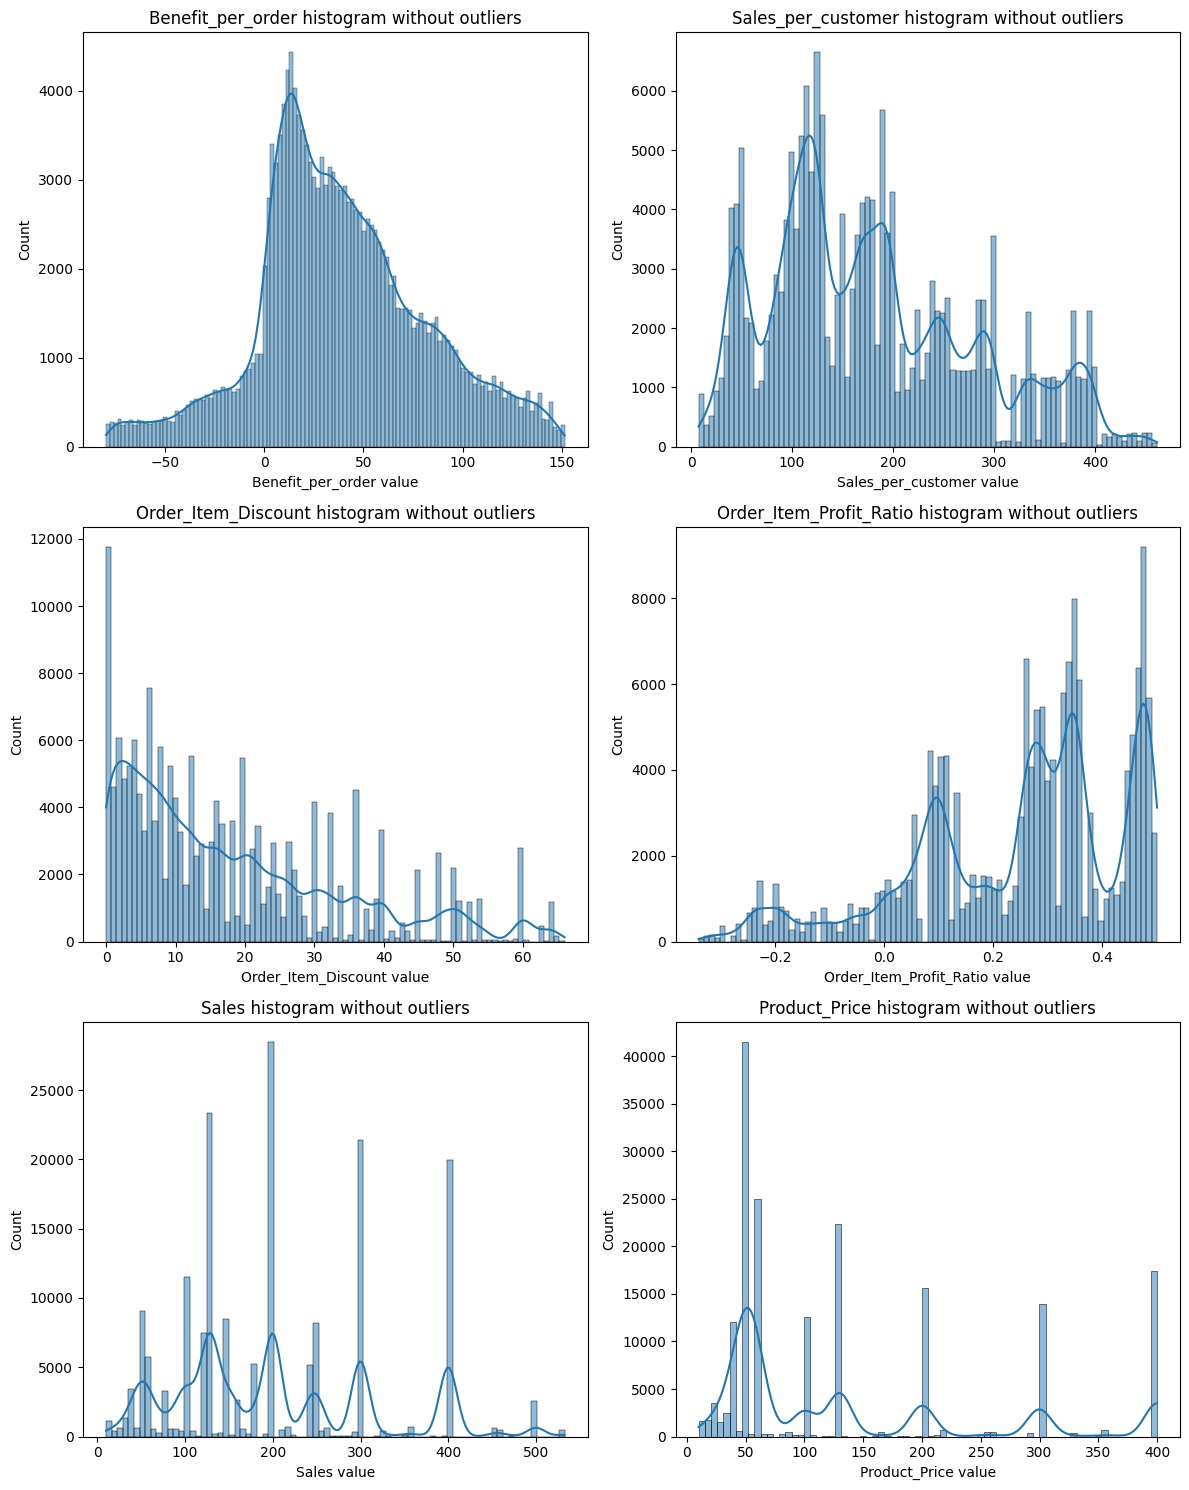

In [14]:
num_rows = len(continous_columns) // 2
if len(continous_columns) % 2 == 0:
    num_cols = 2
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(continous_columns):
    filtered_df = df.drop(df[df[c].isin(outliers_in_columns[c])].index)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.histplot(data=filtered_df, x=c, kde=True, ax=ax)
    ax.set_title(f'{c} histogram without outliers')
    ax.set_xlabel(f'{c} value')
    ax.set_ylabel('Count')

    if num_rows == 1:
        axes[1].axis('off')

if len(continous_columns) % 2 == 1:
    axes[-1][-1].axis('off')

plt.savefig('graphs/Histograms_without_outliers.png')

plt.tight_layout()
plt.show()

In [15]:
df.groupby('Order_Item_Quantity').agg({'Order_Id': 'count',
                                       'Product_Price': 'mean',
                                       'Sales': 'median',
                                       'Sales_per_customer':'max'})

,Order_Id,Product_Price,Sales,Sales_per_customer
Order_Item_Quantity,,,,
1,99134,211.66,199.99,1939.99
2,20315,55.29,100.00,199.98
3,20350,55.56,150.00,300.00
4,20335,55.42,200.00,400.00
5,20385,55.48,250.00,499.95


<AxesSubplot: xlabel='Order_Item_Discount_Rate', ylabel='Count'>

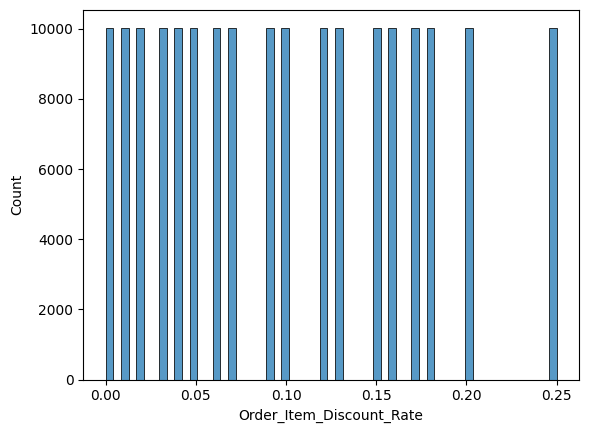

In [16]:
sns.histplot(data=df, x='Order_Item_Discount_Rate')

With these histograms and addition of one aggregative column and visualization of `Order_Item_Discount_Rate`, we can analyse majority of the records in each column and soon I will follow up with outliers analysis. For now, let's focus on the majority.

`Benefit_per_order` presents the profit DataCo Global made on each order. It seems that there are a few thousands of orders, which brought in negative profit. It would be good to analyse these, however at this point, this is not a big issue - the losses are, in this spread, a minority, the mean and median are positive and we can clearly see, that most of the orders brought in profit. It is also somewhere common that not all the products bring in profit, especially at first when they are introduced. The bigger issue to tackle are the large negative benefits, which will be analised next. 

`Sales_per_customer`, as mentioned next to the correlogram, is highly correlated with `Sales` and `Product_Price`, which is quite visible on three grapsh above. These data, as well as it's outliers are in a way related to `Order_Item_Quantities`, even though in the correlogram it is only visible for the price. almost 100k orders were made with quantity of 1, therefore rest of the orders with different quantities are not so well represented. Orders with quantity 1 are robust in prices and lead to majority of the outliers. With larger quantities, the orders include cheaper products - as per the above aggregation it seems the biggest unit price for these is aroung 100 USD. Outliers for all these three columns are on the right from the majority distribution and therefore correspond with the expensive products, which are singular purchases. 

`Order_Item_Discount`, which is the value of the discount on an order is correlated with `Sales` and somewhat correlated with `Product_Price`. All the removed outliers are on the right from the majority distribution, which might suggest, that significant discounts were applied on expensive items. Later on, I will check which products have the highest discount rates and if it helps with the profits.

While on the profit, `Order_Item_Profit_Ratio` is partially a response to the `Benefit_per_order` distribution, as it is a bit similar for this majority subset, Few thousands of the orders have negative profit, just like in benefit, and looking back at the overall distribution, the items with highest profit must be expensive ones, since the profit ratio does not have right outliers. 

That would be the brief analysis of the majority spread and partial analysis of the outliers, as some dependencies were already explained. 

### Outliers analysis
In this part we will take the outliers from `outliers_in_columns` dictionary we created ealrier, to determine the outliers, how these affect profitability and sales at DataCo Global and draw conclusions on how deal with these products, to minimize the negative impact. 

For this part, I will be working on products only, since after all, these are the items that drive or withold sales. My comment on DataCo Global taxonomy structure will be provided later on.

> 💡 If you are following along, visit my Tableau Public Dashboard - [Detailed Department Information](https://public.tableau.com/app/profile/truposzeq/viz/Supply_Chain_Analysis_Dashboard_2/DPC) to compare different product in each department!

In [17]:
benefits_df = df.loc[df['Benefit_per_order'].isin(outliers_in_columns['Benefit_per_order'])]

grouped_benefits_df = benefits_df.groupby('Product_Card_Id').agg({'Benefit_per_order': sum,
                                                                  'Order_Id': 'count',
                                                                  'Order_Item_Quantity': sum,
                                                                 'Product_Price': np.mean,
                                                                 'Order_Item_Profit_Ratio': np.mean,
                                                                 'Order_Item_Discount_Rate': np.mean}).sort_values(by='Benefit_per_order', ascending=False)

grouped_benefits_df.index = grouped_benefits_df.index.map(product_name)

grouped_benefits_df[grouped_benefits_df['Benefit_per_order'] > 0]

,Benefit_per_order,Order_Id,Order_Item_Quantity,Product_Price,Order_Item_Profit_Ratio,Order_Item_Discount_Rate
Product_Card_Id,,,,,,
Dell Laptop,64462.43,380,380,1500.00,0.13,0.10
Lawn mower,14514.39,252,252,532.58,0.11,0.09
Porcelain crafts,3106.27,187,187,461.48,0.03,0.09
Polar FT4 Heart Rate Monitor,945.20,12,56,89.99,0.21,0.06
Bowflex SelectTech 1090 Dumbbells,847.80,4,4,599.99,0.42,0.16
LIJA Women's Mid-Length Panel Golf Shorts,579.06,18,78,100.00,0.00,0.11
The North Face Women's Recon Backpack,576.10,12,51,99.00,0.05,0.11


In [18]:
biggest_losses = grouped_benefits_df[grouped_benefits_df['Benefit_per_order'] < 0].sort_values(by=['Benefit_per_order']).head(10)
biggest_losses

,Benefit_per_order,Order_Id,Order_Item_Quantity,Product_Price,Order_Item_Profit_Ratio,Order_Item_Discount_Rate
Product_Card_Id,,,,,,
Diamondback Women's Serene Classic Comfort Bi,-394995.22,1380,1380,299.98,-1.06,0.10
Perfect Fitness Perfect Rip Deck,-365973.88,1716,6049,59.99,-1.19,0.10
Pelican Sunstream 100 Kayak,-288018.62,1398,1398,199.99,-1.15,0.10
Nike Men's Dri-FIT Victory Golf Polo,-249638.72,1283,4743,50.00,-1.24,0.10
Nike Men's CJ Elite 2 TD Football Cleat,-238308.54,1601,1601,129.99,-1.27,0.09
O'Brien Men's Neoprene Life Vest,-229140.48,1200,4479,49.98,-1.20,0.10
Field & Stream Sportsman 16 Gun Fire Safe,-154163.87,5057,5057,399.98,-0.09,0.09
Nike Men's Free 5.0+ Running Shoe,-135900.20,2360,9656,99.99,-0.28,0.09
Under Armour Girls' Toddler Spine Surge Runni,-100123.08,606,2314,39.99,-1.27,0.10


In [19]:
# for quantity comparison
biggest_losses_index = biggest_losses.index.tolist()

bl_index_count_items = df[(df['Product_Card_Id'].map(product_name)).isin(biggest_losses_index)].groupby('Product_Card_Id').agg({'Order_Id': 'count',
                                                                                                                                'Order_Item_Quantity': sum,
                                                                                                                               'Benefit_per_order': np.mean,
                                                                                                                               'Product_Price': np.mean,
                                                                                                                               'Order_Item_Profit_Ratio': np.mean})
bl_index_count_items.index = bl_index_count_items.index.map(product_name)

bl_index_count_items

,Order_Id,Order_Item_Quantity,Benefit_per_order,Product_Price,Order_Item_Profit_Ratio
Product_Card_Id,,,,,
Nike Men's Free 5.0+ Running Shoe,12169,36680,31.22,99.99,0.12
Perfect Fitness Perfect Rip Deck,24515,73698,20.14,59.99,0.12
Nike Men's CJ Elite 2 TD Football Cleat,22246,22246,14.02,129.99,0.12
Nike Men's Dri-FIT Victory Golf Polo,21035,62956,16.66,50.00,0.12
Under Armour Girls' Toddler Spine Surge Runni,10617,31735,11.89,39.99,0.11
Diamondback Women's Serene Classic Comfort Bi,13729,13729,31.14,299.98,0.12
Field & Stream Sportsman 16 Gun Fire Safe,17325,17325,43.65,399.98,0.12
O'Brien Men's Neoprene Life Vest,19298,57803,16.50,49.98,0.12
Pelican Sunstream 100 Kayak,15500,15500,20.91,199.99,0.12


What is interesting, differently than in the upcoming outliers, where there are singular products that have too high or to low values, in `Benefit_per_order` we can find almost all products (114 from 118), so it's really interesting. This most probably results from unevenly distributed discounts on products and different profitability of the items. 

Firstly we see, that the the most profitable from the outliers was Dell Laptop, which brought in 64 462.43 USD profit. Bowflex SelectTech 1090 Dumbbells is another that has is a pure benefit per order outliers with it's high initial benefit, while the other positive outliers were categorized as outliers due to the quantity and price in connection with higher profitability. In here we see that there are not that many positive outliers and hence we might conclude that positive outliers do not affect the profits as much as negative outliers.

Speak of the devil - negative outliers. I displayed the top 10 products that generate most losses, since these are the most impactful. Other ones, with smalles sum or means might be in these outliers similarely as the positive outlieres, due to higher item price, larger quantity and low profitability or large discound applied. The count of thore are also not that big, which puts those in a reasonable spot.   
However with the outliers displayed we can clearly see on which items DataCo Global is losing profits - **from these top 10 outliets DataCo Global lost over 2.15 M USD in profit.** In here we can distinguish two types of items:
1. Expensive items, where the price might not be covering the original price (from the supplier) or DataCo bought these for too much (unfortunately we do not have the information on the prices from vendors/producers, but I thinkt that this is quite fair conclusion);
2. Items that are slightly expensive, but bought in larger quatities, that greatly reduce DataCo profit. 
Average discounts on these items seem alright, but the profit ratio does not. Hence the assumtion that items were initially bought for higher price than the price on DataCo Global side. 

Later with ABC analysis we will determine if these items are essential to the business. If not, perhaps the best solution to minimize the losses on these would be to  either:
- drop the products (top 10 losses) entirely, OR
- set up a clear prices with the supplier and agree on temporar non-availability if DataCo prices aren't met OR
- set up a limit (e.g. max 2 pieces per order) for the slightly expensive items.

Let's move on to `Sales_per_customer` outliers.

In [20]:
sales_cust_df = df.loc[df['Sales_per_customer'].isin(outliers_in_columns['Sales_per_customer'])]

grouped_sales_cust_df = sales_cust_df.groupby('Product_Card_Id').agg({'Sales_per_customer': sum,
                                                                      'Order_Id': 'count',
                                                                      'Order_Item_Quantity': sum,
                                                                      'Product_Price': np.mean,
                                                                      'Order_Item_Profit_Ratio': np.mean,
                                                                      'Order_Item_Discount_Rate': np.mean}).sort_values(by='Sales_per_customer', 
                                                                                                                        ascending=False)

grouped_sales_cust_df.index = grouped_sales_cust_df.index.map(product_name)
grouped_sales_cust_df.head(10)

,Sales_per_customer,Order_Id,Order_Item_Quantity,Product_Price,Order_Item_Profit_Ratio,Order_Item_Discount_Rate
Product_Card_Id,,,,,,
Dell Laptop,595395.00,442,442,1500.00,0.12,0.10
Nike Men's Free 5.0+ Running Shoe,525760.55,1089,5445,99.99,0.11,0.03
Lawn mower,162274.32,324,324,532.58,0.17,0.06
SOLE E35 Elliptical,26409.85,15,15,1999.99,-0.03,0.12
SOLE E25 Elliptical,9414.90,10,10,999.99,-0.04,0.06
Bushnell Pro X7 Jolt Slope Rangefinder,6062.89,11,11,599.99,-0.02,0.08
Nike Men's Free TR 5.0 TB Training Shoe,4299.55,9,45,99.99,0.27,0.05
Bowflex SelectTech 1090 Dumbbells,4271.92,8,8,599.99,0.20,0.11
Merrell Women's Grassbow Sport Hiking Shoe,3414.65,7,35,99.99,0.38,0.02


In [21]:
# for quantity comparison
sales_cust_ind = grouped_sales_cust_df.head(10).index.tolist()

sales_cust_ind_items = df[(df['Product_Card_Id'].map(product_name)).isin(sales_cust_ind)].groupby('Product_Card_Id').agg({'Order_Id': 'count',
                                                                                                                          'Order_Item_Quantity': sum,
                                                                                                                          'Sales_per_customer': np.mean,
                                                                                                                          'Product_Price': np.mean,
                                                                                                                          'Order_Item_Profit_Ratio': np.mean})
sales_cust_ind_items.index = sales_cust_ind_items.index.map(product_name)

sales_cust_ind_items

,Order_Id,Order_Item_Quantity,Sales_per_customer,Product_Price,Order_Item_Profit_Ratio
Product_Card_Id,,,,,
SOLE E25 Elliptical,10,10,941.49,999.99,-0.04
Nike Men's Free 5.0+ Running Shoe,12169,36680,270.83,99.99,0.12
SOLE E35 Elliptical,15,15,1760.66,1999.99,-0.03
Bowflex SelectTech 1090 Dumbbells,10,10,517.19,599.99,0.23
Fitbit The One Wireless Activity & Sleep Trac,62,187,270.31,99.95,0.11
Nike Men's Free TR 5.0 TB Training Shoe,68,206,272.35,99.99,0.06
Merrell Women's Grassbow Sport Hiking Shoe,70,207,266.64,99.99,0.11
Bushnell Pro X7 Jolt Slope Rangefinder,11,11,551.17,599.99,-0.02
Dell Laptop,442,442,1347.05,1500.00,0.12


For the `Sales_per_customer` we can see that here also we can differentiate two kinds of outliers:
1. Where price is high and therefore generates high sales;
2. Somewhat expensive items that are ordered in larger quantites. 
Also, the expensive item, besides Dell Laptop, Land Mower and Dumbbell set seem to have negative order profit ration. On the other hand, there were only few alike items ordered. 

In this dataset it would also be very useful to see the overall inventory, quatities ordered and how many of those were sold.

Without that we can only see where the outliers come from and draw logical conclusions. Since only few of these item with high sales appeared on the positive outliers of the `Benefit_per_sale` we can assume that  remaining items do not generate large profit, but also don't generate large losses.

Now let's check, which items received the largest discounts.

In [22]:
discounts_df = df.loc[df['Order_Item_Discount'].isin(outliers_in_columns['Order_Item_Discount'])]

                                              
grouped_discounts_df = discounts_df.groupby('Product_Card_Id').agg({'Order_Item_Discount': sum,
                                                                    'Order_Id': 'count',
                                                                    'Order_Item_Quantity': sum,
                                                                    'Product_Price': np.mean,
                                                                    'Order_Item_Profit_Ratio': np.mean,
                                                                    'Order_Item_Discount_Rate': np.mean}).sort_values(by='Order_Item_Discount', ascending=False)

grouped_discounts_df.index = grouped_discounts_df.index.map(product_name)
grouped_discounts_df.head(10)

,Order_Item_Discount,Order_Id,Order_Item_Quantity,Product_Price,Order_Item_Profit_Ratio,Order_Item_Discount_Rate
Product_Card_Id,,,,,,
Field & Stream Sportsman 16 Gun Fire Safe,307980.00,3850,3850,399.98,0.11,0.20
Nike Men's Free 5.0+ Running Shoe,130255.94,1506,6711,99.99,0.13,0.20
Dell Laptop,63960.00,319,319,1500.00,0.13,0.13
Diamondback Women's Serene Classic Comfort Bi,57150.00,762,762,299.98,0.14,0.25
Perfect Fitness Perfect Rip Deck,20472.27,273,1365,59.99,0.16,0.25
Lawn mower,17591.40,187,187,532.58,0.11,0.18
Web Camera,16558.74,198,198,452.04,0.14,0.19
Porcelain crafts,13830.75,162,162,461.48,0.09,0.19
Children's heaters,5874.48,73,73,357.10,0.20,0.23


With these outliers it seems self explanatory, as most of the items here are very expensive. If we apply even slighly lower discount rate, discount amount will be by default high. In two instances in here, high discount amount is due to the quite expensive item bought in larger amount.

In [23]:
sales_df = df.loc[df['Sales'].isin(outliers_in_columns['Sales'])]

                                              
grouped_sales_df = sales_df.groupby('Product_Card_Id').agg({'Sales': sum,
                                                            'Order_Id': 'count',
                                                            'Order_Item_Quantity': sum,
                                                            'Product_Price': np.mean,
                                                            'Order_Item_Profit_Ratio': np.mean,
                                                            'Order_Item_Discount_Rate': np.mean}).sort_values(by='Sales', ascending=False)

grouped_sales_df.index = grouped_sales_df.index.map(product_name)
grouped_sales_df

,Sales,Order_Id,Order_Item_Quantity,Product_Price,Order_Item_Profit_Ratio,Order_Item_Discount_Rate
Product_Card_Id,,,,,,
Dell Laptop,663000.00,442,442,1500.00,0.12,0.10
SOLE E35 Elliptical,29999.85,15,15,1999.99,-0.03,0.12
SOLE E25 Elliptical,9999.90,10,10,999.99,-0.04,0.06
Bushnell Pro X7 Jolt Slope Rangefinder,6599.89,11,11,599.99,-0.02,0.08
Bowflex SelectTech 1090 Dumbbells,5999.90,10,10,599.99,0.23,0.14


`Sales`, similarely with `Sales_per_customer` contains mainly the most expensive items which collectively bring in the highest sales due to their price. 
It is however not refleced on the whole dataset due to low overall quatities ordered.

In [24]:
price_df = df.loc[df['Product_Price'].isin(outliers_in_columns['Product_Price'])]

                                              
grouped_price_df = price_df.groupby('Product_Card_Id').agg({'Product_Price': np.mean,
                                                            'Order_Id': 'count'}).sort_values(by='Product_Price', ascending=False)

grouped_price_df.index = grouped_price_df.index.map(product_name)
grouped_price_df

,Product_Price,Order_Id
Product_Card_Id,,
SOLE E35 Elliptical,1999.99,15
Dell Laptop,1500.00,442
SOLE E25 Elliptical,999.99,10
Bowflex SelectTech 1090 Dumbbells,599.99,10
Bushnell Pro X7 Jolt Slope Rangefinder,599.99,11
Lawn mower,532.58,484
Porcelain crafts,461.48,484
Web Camera,452.04,592


Again, we see the effect of high correlation of Sales, Sales_per_customer and Product_Price, since many of the same items are in the outliers of all group.
On this note, for the product prices it is important to note, that the most expensive items are mainly electronics, fitness and outdoors equipment.

With that, I finish the outliers analysis. which gave us some information on what drives sales and what drives the profits for DataCo Global. We will learn additional details with ABC analysis in the second objective, but now, let's quickly analyse categorical data.

### Categorical data analysis

In this part we will focus on the categorical features of the dataset, firstly the ones that are not geographical.  

### DataCo Taxonomy
Firtsly, I would like to take a short moment to discuss the structure of DataCo Global, departments, categories and products. To put it simply - it's messy. A big reccomendation would be to:
1. Group all the products into correct categories (some clothes are not in clothing categories, some non clothing items are in clothings...);
2. Reduce the number of categories - if the categorie won't be growing, it would be better to create a miscellaneous category that would keep products contained;
3. Do not create categories and more importantly - **departments** with just one products;
That would be the recommendation for the taxonomy of DataCo Global.

In this place, I would communicate this with my team leader and if thie notion would be caught up, we would speak with appropriate people in the company to try and clean up the taxonomy, for easier processing of orders and probably easier web page usage, etc. 

Now we will work with what we have.

For a clean view of the departments, categories and products and the overall view on the items, feel free to view my dashboard for [Detailed Department Information](https://public.tableau.com/app/profile/truposzeq/viz/Supply_Chain_Analysis_Dashboard_2/DPC).   
In here you can go through all the departments and see how each product is performing.

Some of the conclusions are:
- Departments `Health and Beauty`, `Pet Shop`, `Discs Shop`, `Technology` and `Book Shop` were added in the last few months of the DataCo operations;
- Departments `Health and Beauty`, `Pet Shop` and `Book Shop` only have on product in each;
- Department `Fan Shop` is the one that generated the most profit overall, with `Apparel`, `Footwear` and `Golf` being next in line;
- `Technology` department also brought in the highest monthly profit in DataCo Group history, which is over 80k in October 2017;
- Excluding the single-product departments, most of the departments have 1-3 products that are ordered very frequently, with remaining products being barely ordered - the exception in `Outdoors` department, however none of the products has reached 1000 units ordered;
- `Outdoors` has also the most products.

Overall, products in DataCo Global are quite random, which does not create a good image for the brand. In my opinion, the product range is very robust and at the same time - not robust enough in each category/department, where the company could lure in and keep loyal customers, who would buy the OG products but also be able to buy new items. 

In [25]:
product_orders = count_orders(df, 'Product_Card_Id', product_name)
product_items_ordered = count_items_ordered(df, 'Product_Card_Id', product_name)

department_orders = count_orders(df, 'Department_Id', department_name)
department_items_ordered = count_items_ordered(df, 'Department_Id', department_name)

In [26]:
product_df = pd.DataFrame(product_orders)
product_df['Items_sold'] = product_items_ordered
product_df

,Product_Card_Id,Items_sold
Perfect Fitness Perfect Rip Deck,24515,73698
Nike Men's CJ Elite 2 TD Football Cleat,22246,22246
Nike Men's Dri-FIT Victory Golf Polo,21035,62956
O'Brien Men's Neoprene Life Vest,19298,57803
Field & Stream Sportsman 16 Gun Fire Safe,17325,17325
...,...,...
Stiga Master Series ST3100 Competition Indoor,27,27
SOLE E35 Elliptical,15,15
Bushnell Pro X7 Jolt Slope Rangefinder,11,11
Bowflex SelectTech 1090 Dumbbells,10,10


In [27]:
departments_df = pd.DataFrame(department_orders)
departments_df['Items_sold'] = department_items_ordered
departments_df

,Department_Id,Items_sold
Fan Shop,66861,106165
Apparel,48998,98181
Golf,33220,99297
Footwear,14525,43400
Outdoors,9686,26059
Fitness,2479,6227
Discs Shop,2026,2026
Technology,1465,1465
Pet Shop,492,492
Book Shop,405,405


From these two tables above we can see which products are the most popular and sold in largest quatities and also which departments have the most orders. What is worth noting is that the least ordered products are among the most expensive products.

### Other categorical data
In the dataset from DataCo Global we can see a lot of categorical data, even then excluding geographical ones. In the following part we will take a look at the categorical data and how it is spread in the dataset.

One thing to note, I did a whole dashboard on the [Analysis of Delayes Orders](https://public.tableau.com/app/profile/truposzeq/viz/Supply_Chain_Analysis_Dashboard_3/Delays), as it seems that DataCo has some issues with their shipping facility. Majority of the orders are being shipped late, which might be causing dissapointment in customers and therefore worsen the relationship between DataCo and it's customers. If most of the orders are being shipped late, it is highly possible for these to arrive late, which proves low quality of service overall. Isolated incidents or delays around holidays could slide, but as you can see in the dashboard, there is no seasonality in shipment delays. The delays slightly vary between the departments, but for all, most of the orders are shipped at least one day late to the target date. 

This would suggest, that DataCo Global should check on their shipment facility and find why these delays happen - is the facility understaffed, is the place not adjusted to handling great quantities of orders or perhaps managment there is not doing their job well enough? Shipment delays seem to be a big issue for DataCo Global and might lead to overall dissatisfacion of the customers.

Having discussed delay issues, let's move onto some other categorical data.

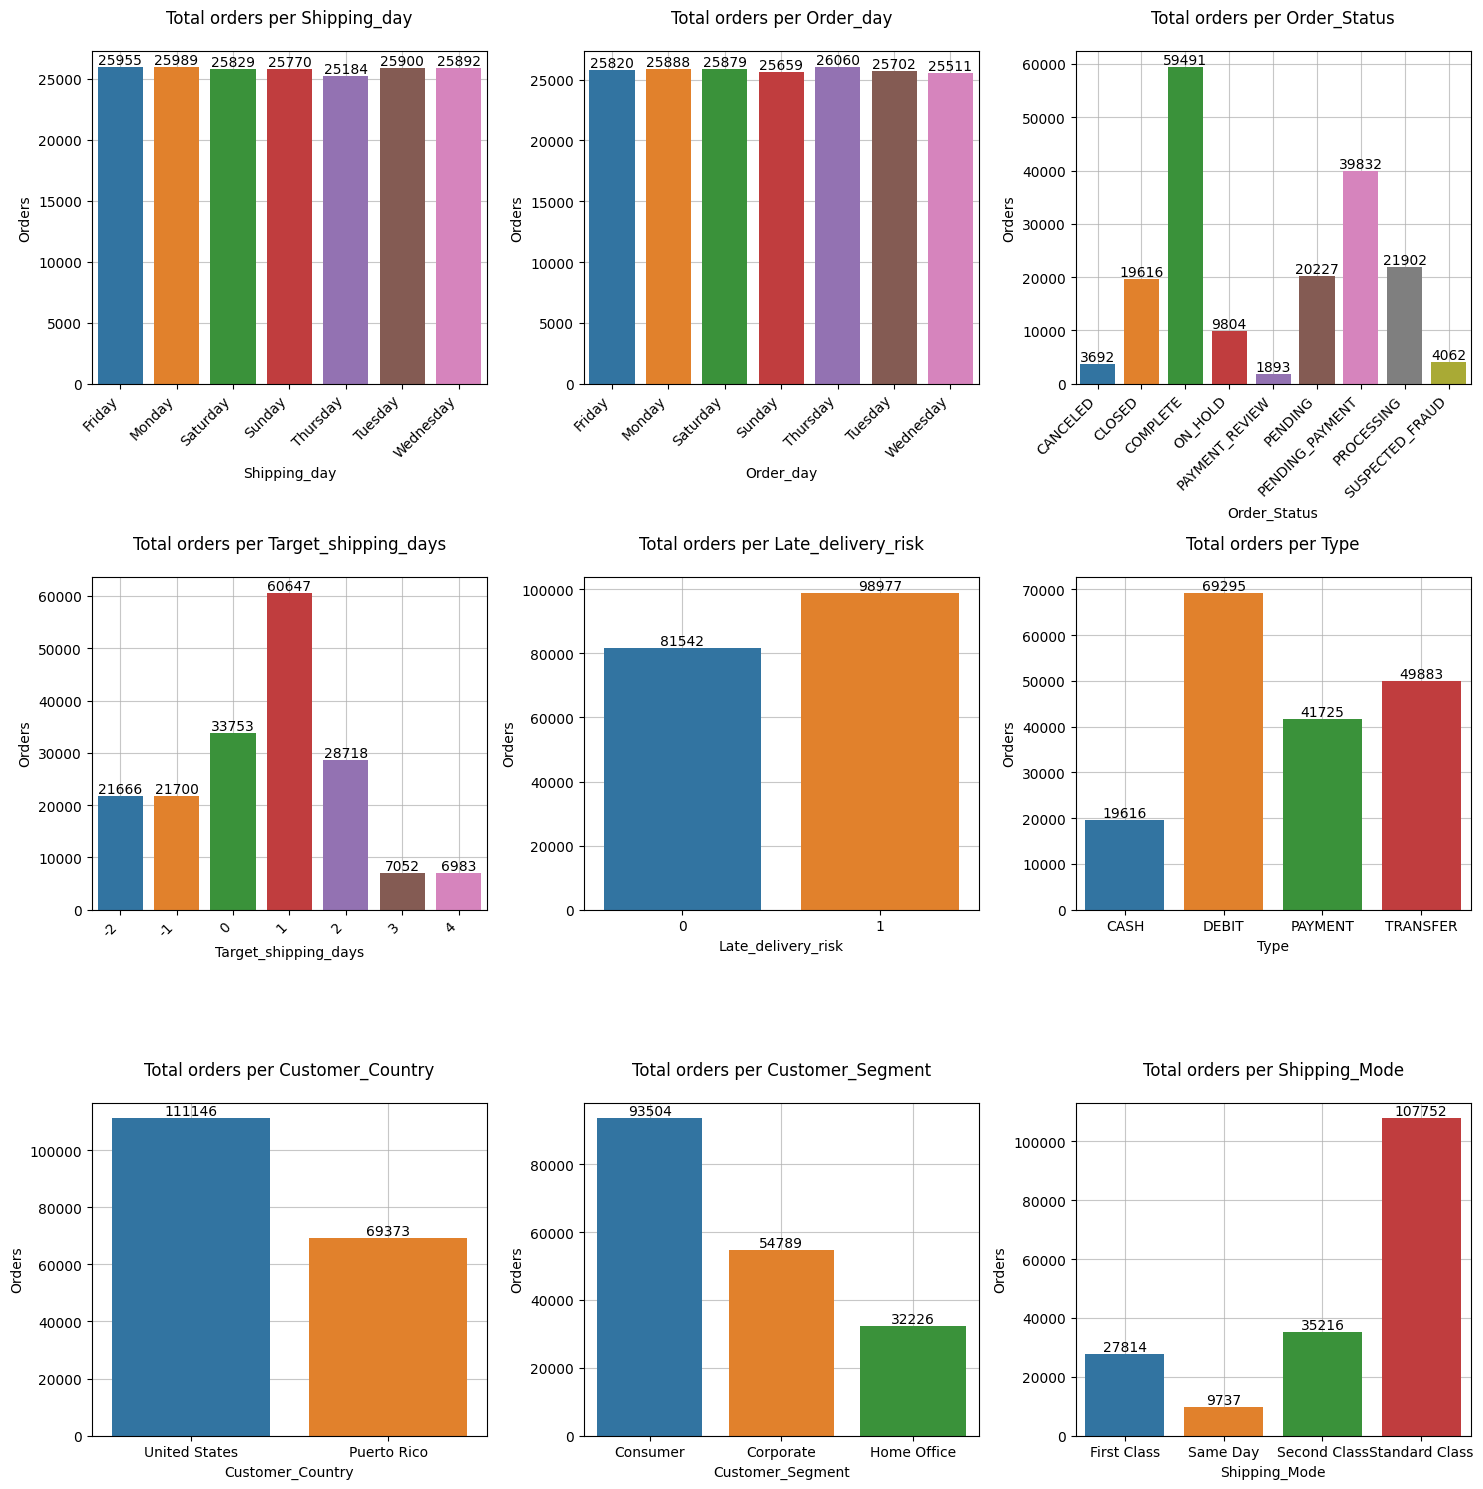

In [28]:
barplots = ['Shipping_day', 'Order_day', 'Order_Status', 
            'Target_shipping_days', 'Late_delivery_risk', 'Type', 
            'Customer_Country', 'Customer_Segment', 'Shipping_Mode']

num_rows = len(barplots) // 3
if len(barplots) % 3 == 0:
    num_cols = 3
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(barplots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    orders = count_orders(df, c)
            
    sns.barplot(x=orders.index, y=orders, ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_title(f'Total orders per {c}', pad=20)
        
    ax.set_xlabel(f'{c}')
    ax.set_ylabel('Orders')
    if len(orders) >= 7:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_axisbelow(True)
    ax.grid(alpha=0.7)

    if num_rows == 1:
        axes[1].axis('off')

if len(barplots) % 3 == 1:
    axes[-1][-1].axis('off')

plt.tight_layout()
plt.show()

From these plots we can conclude that there is no weekly pattern when it comes to both orders and shipments - differences between the days here are small and therefore we can approximate, that each day there are similar orders places and similar order volumes shipped. 

When it comes to the `Order_Status`, we do know that all the orders are from the past, since the company is no longer operating. What is worrying here is that there are 40k orders with pending status - were the data not updated or were there errors when connecting to bank? Perhaps, if DataCo Global offered shipment before payment, they might have lost large amounts of money, if these orders were never to be paid for. This case should be well investigated by the payment team and perhaps banking team to either avoid undetectable fraud. 

In the `Type` column we can see that majority of the orders are paid online, but with it's worldwide shipment, DataCo Global also accepts cash payment. I am interested how Type looks compared to Order Status, if perhaps the pending payments and processing statuses are more common for any type of payment.

`Customer_Country` provides the information on where the orders were placed. DataCo seems to be working on a scheme, where orders are placed in United States and Puerto Rico and then shipped from there wordlwide. Perhaps it is follows a model, where DataCo had consultants in US and Puerto Rico, who placed orders toward third party customers. To my mind it seems to be sligtly overcomplicated, which also might be the reason for the company failure - most of the items offered by DataCo are items easily available on the internet, so that customers from around the world could buy these items themselves. It would lessen the costs on the operational site, perhaps generate new cost for the website maintenance, but such business model would benefit for the company in a long run.

In the `Customer_Segment` we can see that majority of the purchases were made on behalf of individual clients, almost 1/3 were made for corporate and remaining for people working in Home Offices.

`Shipping_Mode` gives an additional insight on the shipment situation at DataCo, which to me makes the shippment issues even worse, as Standard Class shipments should be made within 4 days. It is bizzare that with such long working time. Perhaps there were issues at the other side of the supply chain, that the vendors did not provide the items on time, but while I was cleaning the data there was a column with availability of product for each order and all values there were confirmations that the item is available.

Now that we saw a lot of the data from DataCo Global, let's ask a few additional questions to learn a bit more about the company status. This would also be the place to receive questions from the client or supervisors on what more do they want to learn about the company and based on the data available, conlude some answers and suggestions. For DataCoGlobal, I would like to create **2** additional questions to be answered:
- **Q1:**   How many fraud are suspected for the company? Which departments and products are most often frauded? And how does the fraud (and other order statuses) compare with the payment type?
- **Q2:**   Which destinations generate the largest sales and profits? Is is worthy to sustain worldwide shipping?

### Q1: Fraudulent orders

In [29]:
fraud_proportion = len(df[df['Order_Status'] == 'SUSPECTED_FRAUD']) / len(df)
fraud_num = len(df[df['Order_Status'] == 'SUSPECTED_FRAUD'])
print(f'Total suspected frauds at DataCo Global is {fraud_num} and it is equal to {fraud_proportion * 100} % of the orders.')

Total suspected frauds at DataCo Global is 4062 and it is equal to 2.250178651554684 % of the orders.


In [30]:
fraud_per_dep = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Department_Id') \
                .size().sort_values(ascending=False) / df.groupby('Department_Id').size()

fraud_per_dep.index = fraud_per_dep.index.map(department_name)

fraud_count_per_dep = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Department_Id').size()

fraud_count_per_dep.index = fraud_count_per_dep.index.map(department_name)

#dodaj value_counts()

fraud_info_per_dep = pd.DataFrame({
    'Fraud_Proportion': fraud_per_dep,
    'Fraud_Count': fraud_count_per_dep
}).sort_values('Fraud_Proportion')

fraud_info_per_dep

,Fraud_Proportion,Fraud_Count
Department_Id,,
Discs Shop,0.02,39
Fitness,0.02,54
Technology,0.02,32
Fan Shop,0.02,1483
Pet Shop,0.02,11
Golf,0.02,744
Footwear,0.02,328
Outdoors,0.02,222
Apparel,0.02,1127


It seems that in all the department the suspected frauds are on similar rate. Up to 3% of orders are suspected as frauds, which is pretty low number.

In [31]:
fraud_per_prod = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Product_Card_Id') \
                .size().sort_values(ascending=False) / df.groupby('Product_Card_Id').size()

fraud_count_per_prod = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Product_Card_Id').size()


#dodaj value_counts()

fraud_info_per_prod = pd.DataFrame({
    'Fraud_Proportion': fraud_per_prod,
    'Fraud_Count': fraud_count_per_prod
}).sort_values('Fraud_Proportion')

fraud_info_per_prod.index = fraud_info_per_prod.index.map(product_name)
fraud_info_per_prod.dropna()

,Fraud_Proportion,Fraud_Count
Product_Card_Id,,
adidas Men's F10 Messi TRX FG Soccer Cleat,0.01,2.00
Columbia Men's PFG Anchor Tough T-Shirt,0.01,3.00
Top Flite Women's 2014 XL Hybrid,0.01,3.00
Team Golf Pittsburgh Steelers Putter Grip,0.01,3.00
Titleist Pro V1x High Numbers Golf Balls,0.01,3.00
...,...,...
The North Face Women's Recon Backpack,0.05,3.00
MDGolf Pittsburgh Penguins Putter,0.06,3.00
Diamondback Girls' Clarity 24 Hybrid Bike 201,0.07,2.00


When we compare the fraud rates for products it seems that some products are more likely to be fradulently bought, but still the rates are pretty low, the highes being for Garmin Watch with 8% fraud rate (which still is low, also based on the total frauds on this item equal to 3). What we can notice is that the more expensive items are slightly more likely to be frauded. 

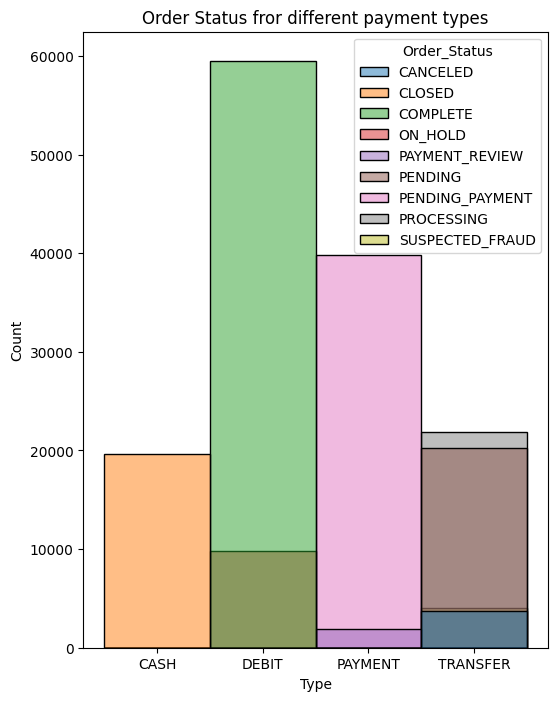

In [32]:
fig, ax = plt.subplots(figsize=(6,8))

ax = sns.histplot(data=df, 
                  x='Type',
                  hue='Order_Status')
ax.set_title('Order Status fror different payment types')

plt.savefig('graphs/Order_Status_for_Payment_Type.png')
plt.show()

From this graph we can deduct that each payment type has it's own order statuses and this might be why there are so many pending and pending_payment statuses. This also suggest that rather than these orders not being paid for, the status is not updated in the dataset as the order is being processed, which is a bad practice. This information should be forwarded to the data engineering team to ensure that the order statuses are up to date.

Fraud is not really visible on this graph, as there are only 2% of frauds in the dataset, so we will do simple grouping to see how many suspected frauds are in each payment type and if it is more common for ones that the others.

In [33]:
fraud_per_type = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Type') \
                .size().sort_values(ascending=False) / df.groupby('Type').size()

fraud_count_per_type = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Type').size()


#dodaj value_counts()

fraud_info_per_type = pd.DataFrame({
    'Fraud_Proportion': fraud_per_type,
    'Fraud_Count': fraud_count_per_type
}).sort_values('Fraud_Proportion')

fraud_info_per_type.dropna()

,Fraud_Proportion,Fraud_Count
Type,,
CASH,0.00,0
DEBIT,0.00,0
PAYMENT,0.00,0
TRANSFER,0.08,4062


From this table we above we can see that frauds are only suspected in the transfer payment types, rounding up to 8% of the transfer payments. Still, there aren't that many frauds, at least of which we know. Perhaps it would be a good practice to implement more fraud detecion on the other payment types, to avoid money losses, but since it is not a huge volume of frauds, I wouldn't call this a priority.

### Q2: Profitability in different regions
For this part we will focus on columns `Market`, `Order_Region` and `Order_Country`.

In [37]:
market_overview = pd.pivot_table(data=df, 
                                 index='Market',
                                 values=['Benefit_per_order', 'Sales', 'Order_Item_Profit_Ratio', 'Order_Id'],
                                 aggfunc={'Benefit_per_order': sum,
                                          'Sales': sum,
                                          'Order_Item_Profit_Ratio':np.mean,
                                         'Order_Id': 'count'}
                                )
market_overview.sort_values(by='Sales', ascending=False)

,Benefit_per_order,Order_Id,Order_Item_Profit_Ratio,Sales
Market,,,,
Europe,1169442.96,50252,0.12,10872396.80
LATAM,1123321.61,51594,0.12,10277612.84
Pacific Asia,857753.44,41260,0.12,8273743.74
USCA,564313.78,25799,0.12,5066528.71
Africa,252071.18,11614,0.12,2294452.93


In [44]:
region_overview = pd.pivot_table(data=df, 
                                 index=['Market', 'Order_Region'],
                                 values=['Benefit_per_order', 'Sales', 'Order_Item_Profit_Ratio', 'Order_Id'],
                                 aggfunc={'Benefit_per_order': sum,
                                          'Sales': sum,
                                          'Order_Item_Profit_Ratio':np.mean,
                                         'Order_Id': 'count'}
                                )
region_overview = region_overview.dropna()
region_overview.sort_values(by='Sales', ascending=False)

Benefit_per_order  Order_Id  \
Market       Order_Region                                   
Europe       Western Europe           625446.08     27109   
LATAM        Central America          616341.57     28341   
             South America            335154.40     14935   
Europe       Northern Europe          233450.60      9792   
             Southern Europe          230829.23      9431   
Pacific Asia Oceania                  201478.02     10148   
             Southeast Asia           211342.82      9539   
LATAM        Caribbean                171825.64      8318   
USCA         West of USA              164940.66      7993   
Pacific Asia South Asia               165703.90      7731   
             Eastern Asia             147368.01      7280   
USCA         East of USA              156263.30      6915   
Pacific Asia West Asia                118815.41      6009   
USCA         US Center                131094.23      5887   
             South of  USA             88114.88      4045   
Europe       Eastern Europe            79717.05      3920   
Africa       West Africa               80030.27      3696   
             North Africa              64599.86      3232   
             East Africa               43167.73      1852   
             Central Africa            33447.27      1677   
             Southern Africa           30826.05      1157   
USCA         Canada                    23900.71       959   
Pacific Asia Central Asia              13045.28       553   

                              Order_Item_Profit_Ratio      Sales  
Market       Order_Region                                         
Europe       Western Europe                      0.12 5894380.77  
LATAM        Central America                     0.12 5665712.10  
             South America                       0.12 2960881.41  
Europe       Northern Europe                     0.12 2155830.65  
             Southern Europe                     0.13 2047918.82  
Pacific Asia Oceania                             0.11 2016654.20  
             Southeast Asia                      0.12 1932495.57  
LATAM        Caribbean                           0.12 1651019.33  
USCA         West of USA                         0.12 1571415.96  
Pacific Asia South Asia                          0.12 1553680.92  
             Eastern Asia                        0.11 1486401.34  
USCA         East of USA                         0.13 1371111.99  
Pacific Asia West Asia                           0.12 1174671.78  
USCA         US Center                           0.12 1151355.77  
             South of  USA                       0.12  785783.95  
Europe       Eastern Europe                      0.11  774266.57  
Africa       West Africa                         0.12  727951.19  
             North Africa                        0.12  634752.22  
             East Africa                         0.14  376234.90  
             Central Africa                      0.11  327263.02  
             Southern Africa                     0.15  228251.59  
USCA         Canada                              0.14  186861.04  
Pacific Asia Central Asia                        0.13  109839.93

In [39]:
regions = df['Order_Region'].unique().tolist()
regions_top5 = {}

for region in regions:
    if region not in regions_top5.keys():
        reg_set = df[df['Order_Region'] == region]
        grouped = reg_set.groupby('Product_Card_Id').agg({'Order_Id': 'count',
                                                          'Sales': sum,
                                                          'Benefit_per_order': np.mean}) \
                                                .sort_values(by='Order_Id', ascending=False)
        
        grouped.index = grouped.index.map(product_name)
        regions_top5[region] = grouped[:5]

for key in regions_top5.keys():
    print(f'{key} {regions_top5[key]} \n')

Central America                                            Order_Id      Sales  \
Product_Card_Id                                                  
Perfect Fitness Perfect Rip Deck               4035  729718.38   
Nike Men's CJ Elite 2 TD Football Cleat        3620  470563.82   
Nike Men's Dri-FIT Victory Golf Polo           3404  517100.00   
O'Brien Men's Neoprene Life Vest               3239  487504.92   
Field & Stream Sportsman 16 Gun Fire Safe      2822 1128743.59   

                                           Benefit_per_order  
Product_Card_Id                                               
Perfect Fitness Perfect Rip Deck                       19.70  
Nike Men's CJ Elite 2 TD Football Cleat                12.78  
Nike Men's Dri-FIT Victory Golf Polo                   16.23  
O'Brien Men's Neoprene Life Vest                       16.58  
Field & Stream Sportsman 16 Gun Fire Safe              47.58   

South America                                            Order_Id     Sales  \

It seems that all regions generate profits and sales, which is positive for the company.

DataCo Global receives the most orders and sales from orders addressed to Europe and LATAM, so DataCo should aim at these two destinations with their sales.

It also seems that top 5 popular products for each region are similar, if not almost the same for each region. Therefore it seems that selling worldwide might have it's benefits for DataCo Global. However, since the company is failing, I would reconsider scaling down, gaining some more recognision in Europe and LATAM, earn some more loyal customers and when the company is more stable, continue with the expansion.

## Objective 2: ABC Analysis
ABC analysis is an inventory management technique that determines the value of inventory items based on their importance to the business. ABC ranks items on demand, cost and risk data, and inventory mangers group items into classes based on those criteria.

To put it simply, abc analysis will allow us to split product of DataCo Global into three categories and rate it's importance for the business.
![abc classification](https://www.sagesoftware.co.in/wp-content/uploads/2023/05/imgpsh_fullsize_anim-76-1024x726.jpg)

With that, we will decide which products are essential for the integrity and keeping up the sales. With the wide variety of DataCo products this might help us decide on which products the company should focus to rebuild the customer base and raise the sales one again.

In [116]:
abc_analysis_df = df.groupby('Product_Card_Id')[['Order_Item_Quantity', 'Sales']].sum()
abc_analysis_df.index = abc_analysis_df.index.map(product_name)
abc_analysis_df = abc_analysis_df.reset_index()

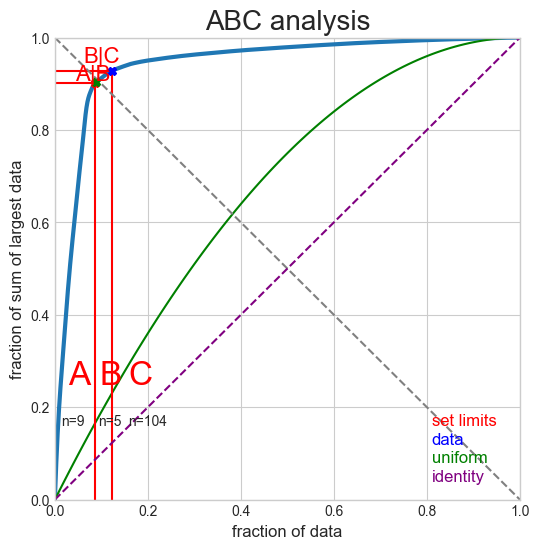

In [117]:
abc = abc_analysis(abc_analysis_df['Sales'], True)

In [118]:
a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

cond_list = [abc_analysis_df.index.isin(a_index),
             abc_analysis_df.index.isin(b_index),
             abc_analysis_df.index.isin(c_index)]

choice = ['A', 'B', 'C']

abc_analysis_df['abc'] = np.select(cond_list, choice)

In [123]:
abc_analysis_df[abc_analysis_df['abc'] =='A'].sort_values(by='Order_Item_Quantity',
                                                          ascending=False)

,Product_Card_Id,Order_Item_Quantity,Sales,abc
35,Perfect Fitness Perfect Rip Deck,73698,4421143.14,A
37,Nike Men's Dri-FIT Victory Golf Polo,62956,3147800.00,A
97,O'Brien Men's Neoprene Life Vest,57803,2888993.91,A
15,Nike Men's Free 5.0+ Running Shoe,36680,3667633.20,A
44,Under Armour Girls' Toddler Spine Surge Runni,31735,1269082.67,A
36,Nike Men's CJ Elite 2 TD Football Cleat,22246,2891757.66,A
96,Field & Stream Sportsman 16 Gun Fire Safe,17325,6929653.69,A
99,Pelican Sunstream 100 Kayak,15500,3099845.09,A
92,Diamondback Women's Serene Classic Comfort Bi,13729,4118425.57,A


In [124]:
abc_analysis_df[abc_analysis_df['abc'] =='B'].sort_values(by='Order_Item_Quantity',
                                                          ascending=False)

,Product_Card_Id,Order_Item_Quantity,Sales,abc
104,Children's heaters,652,232829.20,B
103,Web Camera,592,267607.69,B
107,Porcelain crafts,484,223356.33,B
109,Lawn mower,484,257768.73,B
105,Dell Laptop,442,663000.00,B


From the picture I attached above, with the percentages provided in there, it seems that not even 20% of the products in DataCo portfolio are in groups A or B. This is bad for the company, but suggest the preferences of DataCo clients.

From what it looks like, all of the items in **A** category are sport-related. Sport gear, bicycle, gun safe, kayak, fitness apparel. It looks like DataCo should perhaps call itself SportCo? The quantities sold and sales generated speak by itself.

When it comes to the B category, the items in here are more random, but brought in substantial sales to the company. These are electronics, lawn mower, porcelain crafts and a heater. What also speaks volumes here is that Dell Laptop and Web Camera were added to the shop inventory shortly before the closing, which puts all the remaining items, in C category, even less appealing to the business.

With that known, let's move onto the last objective.

## Objective 3: Conclusions
I would like to start this segment with recommentations for DataCo Global, which perhaps would have been useful if applied in point, in which the dataset ends.
1. Redo the whole inventory and create niche specific portfolio:
    - DataCo seems to be doing well with selling fitness related items - this should make the brand, not random items;
    - Remove the items that are not related to fitness in any way - like men's gala suit or dog supplies;
    - Make the structure of departments and categories simpler, skip the unwanted departmens/categories and if there are few items that do not belong to any category or department, create one that will cover whese and similar items in the future;
2. Control the discount rates for the items overtime;
3. Create a website for the clients to buy directly from DataCo;
4. Either restructure and train the shipment staff or change the facility, so that the orders would be shipped within the the time given on a normal basis;
5. Conduct additional analysis on the negative outlier records for the `Benefit_per_order` column, so that DataCo knows why these happened and avoid them in the future (wether it is due to seller error, system error, change in supplier product prices, etc)
6. Rething the `Order_status` value, as it is different for all payment types and perhaps ensure that data engineers help with it's updates;
7. Consider fraud detection on all payment types, not only on Transfer payments;
8. For the time-being, focus on Europe and LATAM markets, to draw more customers in and expand when the sales stabilize.

Overall, I think that the reason why the company failed, strictly based on the data, would be the declining sales and orders. This might be due to few different reasons, which I hinted before:
- great delays in order shipments;
- unorganized structure of the portfolio and random choice in the items;
- not detecting highly unprofitable sales in time and letting it grow;
- random additions of the items not related to the store;
- no brand identity, which speaks through the portfolio.

In conclusion, if DataCo Global wanted to keep the company running, they should have cleaned up the presented issues and perhaps invest in branding and marketing. Aim at specific customers, sport enthustiast and fitness freaks, as it seems this was the driving factor behind the sales. Generating interest in the customers, offering wide variety of sport related products (and not books or laptops) and good tracking of orders perhaps could have saved the company.

Thank you so much for reading my analysis!

![img](https://www.comarch.com/files-com/file_691/supply-chain-management.png)